In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [38]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = np.load(fpath + "data_signal_with_sine" + ".npy")

sig_with_artifact.shape

(1000, 4000)

Text(0.5, 1.0, 'Original Signal')

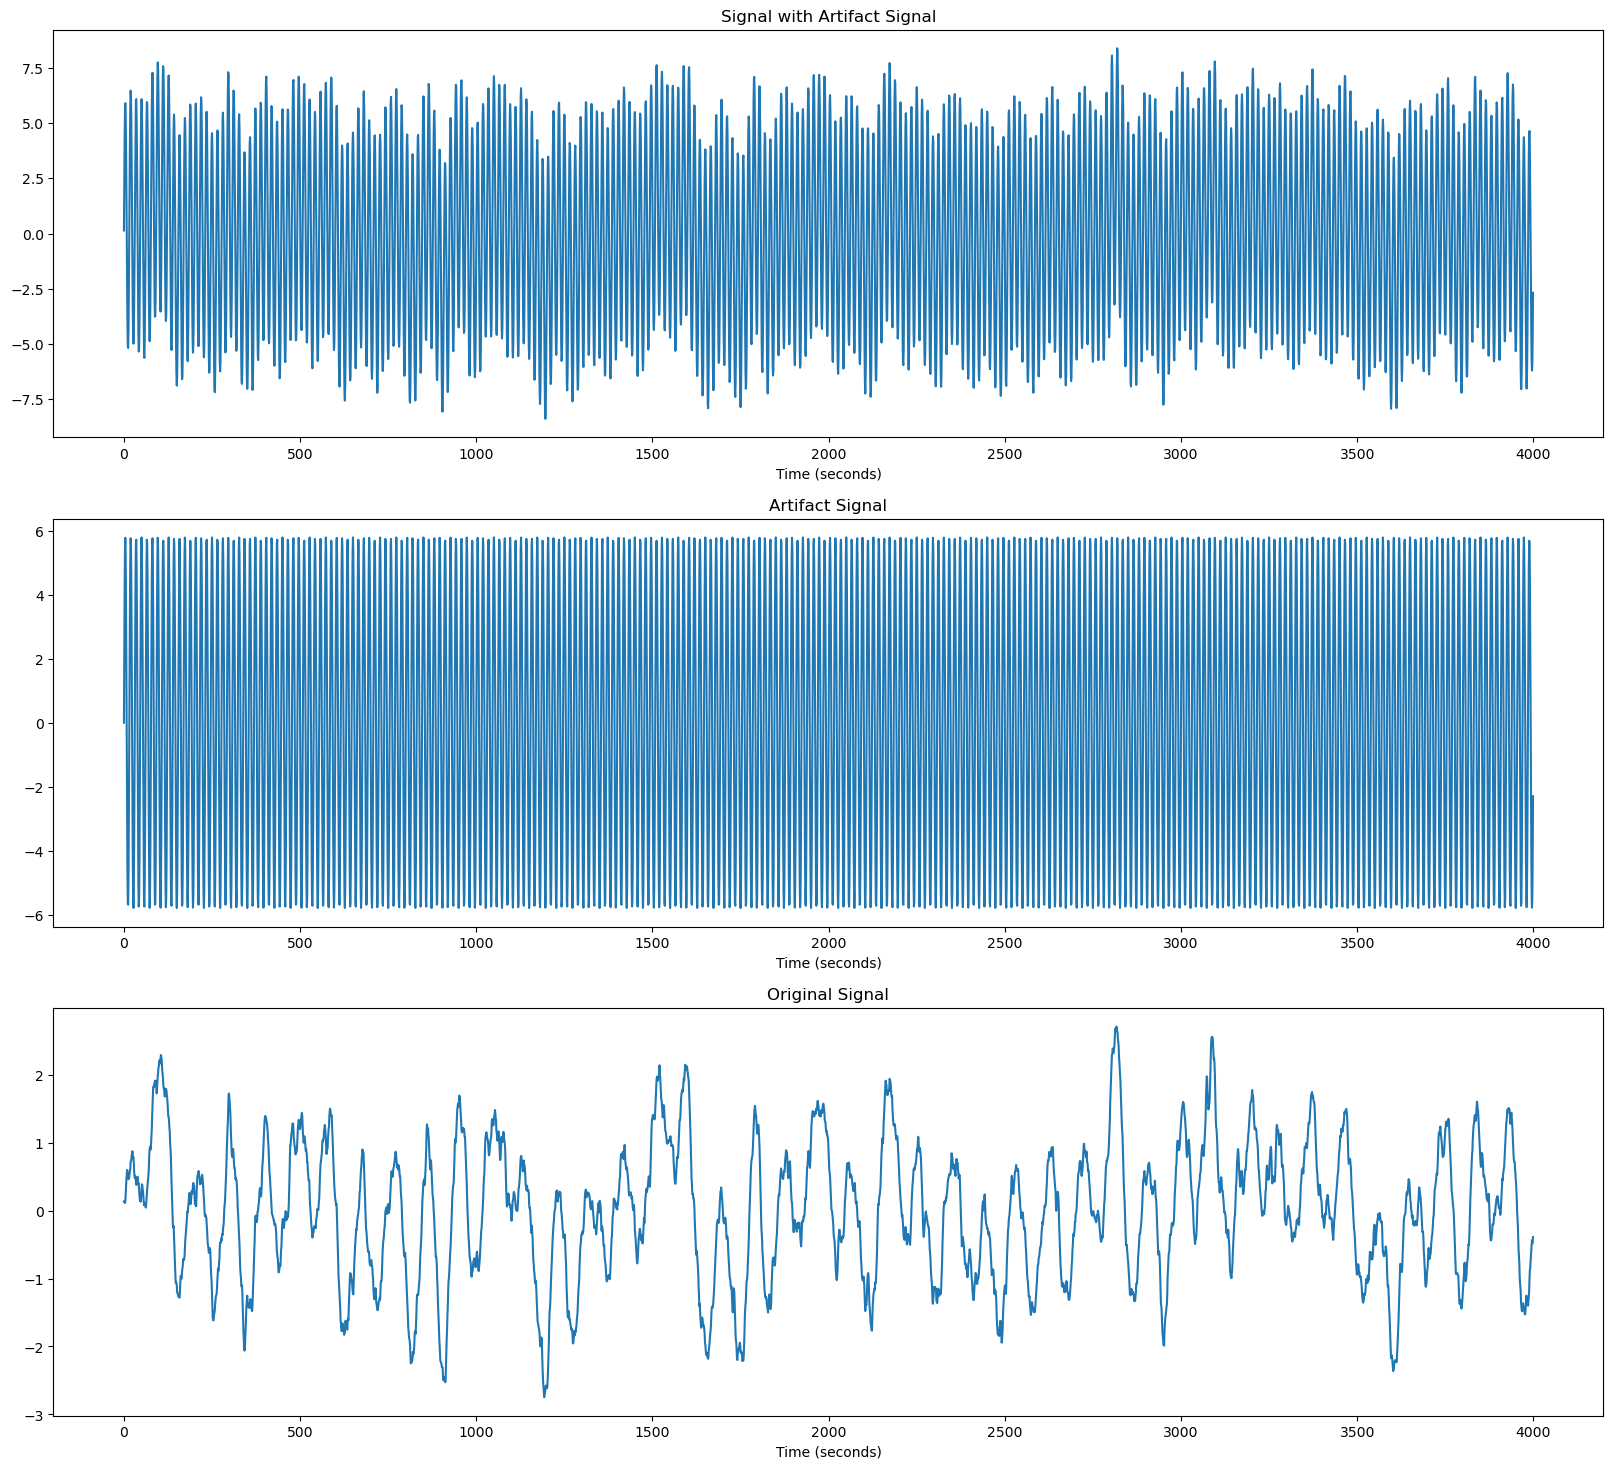

In [39]:
plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(sig_with_artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(artifact[0])
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(sig[0])
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

In [40]:
# 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(sig_with_artifact).reshape(1000, 4000, 1)
y = scaler.fit_transform(sig).reshape(1000, 4000, 1)

print(X.shape)
print(y.shape)

(1000, 4000, 1)
(1000, 4000, 1)


In [41]:
num_data = X.shape[0] # 1000
num_timepoints = X.shape[1] # 4000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([800, 4000, 1])
torch.Size([800, 4000, 1])
torch.Size([200, 4000, 1])
torch.Size([200, 4000, 1])


In [42]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # hidden layer의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.relu(output)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [43]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기 (sine wave와 synthesized 신호)
hidden_size = 16  # 임의의 hidden layer 크기
num_layers = 2  # 임의의 LSTM layer 개수
num_classes = 1  # 출력 크기 (original 신호)
seq_length = num_timepoints  # 시퀀스 길이 (4000)

model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# 모델 훈련
num_epochs = 50
batch_size = 50

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        # Forward pass
        outputs = model(X_batch).to(device)
        optimizer.zero_grad()
        
        # Calculate loss
        loss = criterion(outputs, y_batch.view(-1, num_classes))
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    if epoch%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/50], Loss: 0.06470843404531479
Epoch [2/50], Loss: 0.025439376011490822
Epoch [3/50], Loss: 0.025312557816505432
Epoch [4/50], Loss: 0.024430612102150917
Epoch [5/50], Loss: 0.02222628891468048
Epoch [6/50], Loss: 0.011520606465637684
Epoch [7/50], Loss: 0.005968558136373758
Epoch [8/50], Loss: 0.004516566637903452
Epoch [9/50], Loss: 0.0036257354076951742
Epoch [10/50], Loss: 0.0031142602674663067
Epoch [11/50], Loss: 0.0027779042720794678
Epoch [12/50], Loss: 0.0025487663224339485
Epoch [13/50], Loss: 0.002399092074483633
Epoch [14/50], Loss: 0.002298676874488592
Epoch [15/50], Loss: 0.002221649046987295
Epoch [16/50], Loss: 0.0021588136442005634
Epoch [17/50], Loss: 0.0021063005551695824
Epoch [18/50], Loss: 0.0020623430609703064
Epoch [19/50], Loss: 0.0020242787431925535
Epoch [20/50], Loss: 0.0019903506617993116
Epoch [21/50], Loss: 0.0019579592626541853
Epoch [22/50], Loss: 0.0019201429095119238
Epoch [23/50], Loss: 0.0018869865452870727
Epoch [24/50], Loss: 0.0018774798

In [45]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test.view(-1, num_classes))
    print(f'Validation Loss: {val_loss.item():.4f}')


Validation Loss: 0.0009


torch.Size([800, 1000, 1])


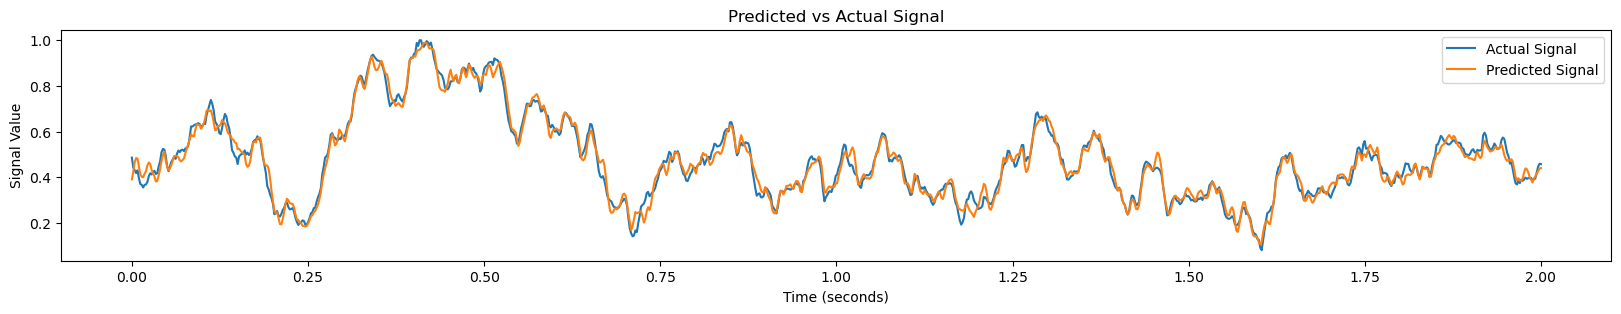

Mean Absolute Error: 0.022412361577153206
Mean Squared Error: 0.0008204710902646184


In [46]:
# 검증 데이터 중 첫 번째 샘플에 대한 예측과 실제 값을 플롯
val_outputs = val_outputs.view(-1, num_data, num_classes)  # reshape to (batch_size, num_data, num_classes)
y_test = y_test.view(-1, num_data, num_classes)
print(y_test.shape)

# 첫 번째 샘플의 첫 번째 신호만 선택하여 플롯 (여러 신호 중 하나만 플롯하는 예시)
sample_idx = 0
signal_idx = 0

predicted_signal = val_outputs[sample_idx, :, signal_idx].cpu().numpy()
actual_signal = y_test[sample_idx, :, signal_idx].cpu().numpy()

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=num_data) 

plt.figure(figsize=(20, 3))
plt.plot(time_steps, actual_signal, label='Actual Signal')
plt.plot(time_steps, predicted_signal, label='Predicted Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

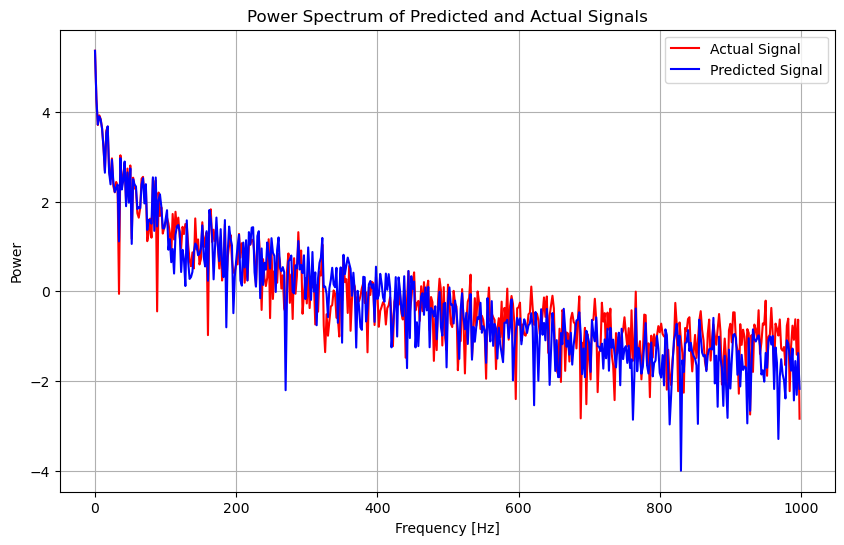

Mean Absolute Error: 0.46213526401484795
Mean Squared Error: 0.39180449741206325


In [47]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power1 = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power2 = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power2), label='Actual Signal', color='red')
plt.plot(freqs, np.log10(power1), label='Predicted Signal', color='blue')
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power2), np.log10(power1))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power2), np.log10(power1))}")